<a href="https://colab.research.google.com/github/lmbd92/st1800-st1801-trabajo3-2261/blob/main/Trabajo3Lina_Jose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Integrantes: Lina Beltrán (lbeltra1@eafit.edu.co), Jose Muñoz (jjmunozm@eafit.edu.co)

Materia: Alm. & Recu. de información.

Trabajo 3

Universidad EAFIT - Maestria ciencia en datos y analítica

Trabajo 2 Unidad 2 recuperación de texto

Data: https://github.com/lmbd92/st1800-st1801-trabajo3-2261/blob/main/Trabajo3/twitter.txt

# Abrir archivos desde GitHub

In [1]:
# OJO!!!! Ejecutar este bloque una sola vez (Por cada sesión iniciada)

!git clone -l -s https://github.com/lmbd92/st1800-st1801-trabajo3-2261.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 126 (delta 74), reused 17 (delta 5), pack-reused 0
Receiving objects: 100% (126/126), 32.10 MiB | 11.64 MiB/s, done.
Resolving deltas: 100% (74/74), done.
/content/cloned-repo
LICENSE    Trabajo3		    twitterClimateData.csv.zip
README.md  Trabajo3Lina_Jose.ipynb


In [2]:
# Delete repo local colab (Usar solo en caso de requerir actualizar el repo desde Github Nuevamente)

#!rm -r /content/cloned-repo

**Nota:** Para guardar el notebook directamente en Github, dirigirse a File→Save a copy in GitHub

# Preparación de ambiente de trabajo (Dependencias/librerias)

In [1]:
# Transmisión eficiente de archivos muy grandes desde/hacia almacenamientos como S3, GCS, Azure Blob Storage, HDFS, WebHDFS
!pip install smart-open

# Modelado y procesamiento NLP
!pip install --upgrade gensim
!pip install nltk

# Interpretar el tema en un modelo de temas que se ha ajustado a un corpus
!pip install pyLDAvis

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib as plt
# Soporte para expresiones regulares (RE).
import re

In [3]:
# nltk: tokenizador y stopwords

from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words_nltk = set(stopwords.words('english'))
print(len(stopwords.words('english')))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
179


In [4]:
#Lematizar, Stem
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
#
lancaster = LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [5]:
#imprimir listas grandes
import pprint
from pprint import pprint

# Carga de Data Raw y EDA básico



In [6]:
# Carga de los datos

path_in = '/content/cloned-repo/Trabajo3/'
path_out = '/content/cloned-repo/Trabajo3/out/'
file_name = 'twitterClimateData.csv'

df = pd.read_csv(f'{path_in}{file_name}')
df.head()

,Unnamed: 0,id,author_id,text,retweets,permalink,date,formatted_date,favorites,mentions,...,location,text_clean,tb_sentiment_polarity,tb_sentiment_subjectivity,textBlob_sentiment,vader_compound,vader_pos,vader_neg,vader_neu,V_Sentiment
0,0,1.211810e+18,7.590000e+17,"2020 is the year we #votethemout, the year we ...",15,https://twitter.com/Sphiamia/status/1211807074...,2019-12-31 00:31:35+00:00,Tue Dec 31 00:31:35 +0000 2019,46,NaN,...,"California, USA",2020 is the year we votethemout the year we cl...,-0.100000,0.462500,negative,-0.5682,0.000,0.131,0.869,Negative
1,1,1.210670e+18,2.219547e+07,Winter has not stopped this group of dedicated...,9,https://twitter.com/StephDujarric/status/12106...,2019-12-27 20:56:21+00:00,Fri Dec 27 20:56:21 +0000 2019,35,NaN,...,"California, USA",Winter has not stopped this group of dedicated...,0.000000,0.000000,positive,0.5670,0.215,0.000,0.785,Positive
2,2,1.210590e+18,1.070000e+18,WEEK 55 of #ClimateStrike at the @UN. Next wee...,545,https://twitter.com/AlexandriaV2005/status/121...,2019-12-27 15:50:22+00:00,Fri Dec 27 15:50:22 +0000 2019,3283,@UN @Fridays4future,...,"California, USA",WEEK 55 of ClimateStrike at the UN Next week F...,0.166667,0.333333,positive,-0.8567,0.023,0.180,0.797,Negative
3,3,1.210260e+18,1.339821e+09,"A year of resistance, as youth protests shape...",1,https://twitter.com/EnergyHouseVA/status/12102...,2019-12-26 17:53:26+00:00,Thu Dec 26 17:53:26 +0000 2019,2,NaN,...,"California, USA",A year of resistance as youth protests shaped...,0.183333,0.600000,positive,0.7739,0.203,0.051,0.746,Positive
4,4,1.209640e+18,1.339821e+09,HAPPY HOLIDAYS #greta #gretathunberg #climate...,1,https://twitter.com/EnergyHouseVA/status/12096...,2019-12-25 00:56:37+00:00,Wed Dec 25 00:56:37 +0000 2019,4,NaN,...,"California, USA",HAPPY HOLIDAYS greta gretathunberg climatecha...,0.650000,0.800000,positive,0.9413,0.451,0.000,0.549,Positive


In [7]:
df.shape

(72405, 24)

In [8]:
df.count()

Unnamed: 0                   72405
id                           72405
author_id                    72405
text                         72405
retweets                     72405
permalink                    72405
date                         72405
formatted_date               72405
favorites                    72405
mentions                     27554
hashtags                     72402
geo                              0
urls                         33349
search_hashtags              72405
location                     72405
text_clean                   72405
tb_sentiment_polarity        72405
tb_sentiment_subjectivity    72405
textBlob_sentiment           72405
vader_compound               72405
vader_pos                    72405
vader_neg                    72405
vader_neu                    72405
V_Sentiment                  72405
dtype: int64

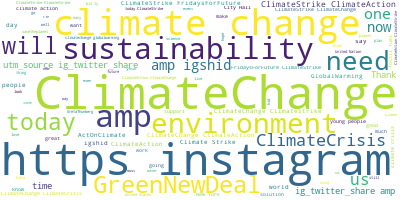

In [9]:
# Importar wordcloud Libreria
from wordcloud import WordCloud
# Unir palabras y caracteres Raw
long_string = ','.join(list(df['text'].values))
# Crear objeto de nube de palabras
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generar nube de palabras
wordcloud.generate(long_string)
# Visualización
wordcloud.to_image()

# Preparación de data, Nubes de tokens y Frecuencia

Definimos funcion para optimizar incluyendo stem y Lematización

In [10]:
def textprep(line):
    tokens = nltk.word_tokenize(str(line))
    tokens = [w.lower() for w in tokens if len(w)>1]
    tokens = [re.sub(r'[^A-Za-z0-9]+','',w) for w in tokens]
    tokens = [w for w in tokens if w not in stop_words_nltk] 
    tokens= [wordnet_lemmatizer.lemmatize(w) for w in tokens]
    tokens= [lancaster.stem(w) for w in tokens]
    return tokens

In [11]:
#Filtramos solo la columna de interés
text_df = df[['text']]
text_df.head()

,text
0,"2020 is the year we #votethemout, the year we ..."
1,Winter has not stopped this group of dedicated...
2,WEEK 55 of #ClimateStrike at the @UN. Next wee...
3,"A year of resistance, as youth protests shape..."
4,HAPPY HOLIDAYS #greta #gretathunberg #climate...


In [12]:
# creación de columna con tokenización de la columna de interés especifica
text_df['tokens_twitter'] = text_df.apply(lambda row: textprep(row['text']), axis=1)
text_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,tokens_twitter
0,"2020 is the year we #votethemout, the year we ...","[2020, year, votethemout, year, climatestrik, ..."
1,Winter has not stopped this group of dedicated...,"[wint, stop, group, ded, clim, act, exampl, fo..."
2,WEEK 55 of #ClimateStrike at the @UN. Next wee...,"[week, 55, climatestrik, un, next, week, frida..."
3,"A year of resistance, as youth protests shape...","[year, resist, you, protest, shap, clim, chang..."
4,HAPPY HOLIDAYS #greta #gretathunberg #climate...,"[happy, holiday, gret, gretathunberg, climatec..."


Representación Frecuencia Visual del BoW optimizado

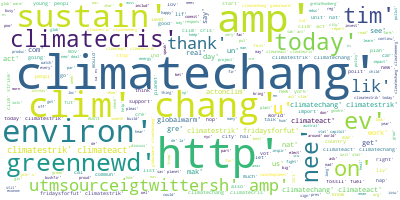

In [13]:
#Convertir Tokens en Lista y Str
tokens_twitter_list=text_df['tokens_twitter'].to_list()
tokens_twitter_str=" ".join([str(item) for item in tokens_twitter_list])
# Crear nube de palabras
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generar nube de palabras
wordcloud.generate(tokens_twitter_str)
# Visualización
wordcloud.to_image()

# Características y representación

Construir el BoW (diccionario) de términos

In [14]:
# Creación del BoW - en gensim es Dictionary
from gensim.corpora import Dictionary
dictionary = Dictionary(text_df.tokens_twitter)
print(dictionary)

Dictionary(77295 unique tokens: ['2020', '33', 'climatestrik', 'don', 'els']...)


In [15]:
# Bag-of-words representacion de documentos.
corpus = [dictionary.doc2bow(line) for line in text_df.tokens_twitter]

In [16]:
for i in corpus[:10]:
    print(i)

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 4)]
[(2, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]
[(0, 1), (2, 1), (6, 1), (15, 1), (16, 1), (17, 1), (24, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2)]
[(0, 1), (2, 1), (15, 1), (16, 1), (17, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2)]
[(2, 1), (17, 1), (49, 1), (51, 1), (52, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (63, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1)]
[(2, 1), (17, 2), (36, 1), (50, 1), (52, 1), (54, 1), (56, 1), (57, 1), (78, 1), (79,

Construir matriz de documentos vs términos

In [17]:
# libreria para paralelizar
import multiprocessing as mp
import time

pool = mp.Pool(mp.cpu_count())
doc_term_matrix = pool.map(dictionary.doc2bow, [sentence for sentence in text_df.tokens_twitter])
pool.close()

In [18]:
for i in doc_term_matrix[:10]:
    print(i)

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 4)]
[(2, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]
[(0, 1), (2, 1), (6, 1), (15, 1), (16, 1), (17, 1), (24, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2)]
[(0, 1), (2, 1), (15, 1), (16, 1), (17, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2)]
[(2, 1), (17, 1), (49, 1), (51, 1), (52, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (63, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1)]
[(2, 1), (17, 2), (36, 1), (50, 1), (52, 1), (54, 1), (56, 1), (57, 1), (78, 1), (79,

# Modelo no supervisado LDA

Modelo LDA

In [19]:
#from gensim.models.ldamulticore import LdaMulticore

#t0 = time.time()
#lda_model = LdaMulticore(doc_term_matrix, num_topics=20, id2word = dictionary, passes=10, workers=10)
#print(time.time()-t0)

In [20]:
# Build LDA model Otro modelo lda, tiene otro nombr para no confundirse
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel


Corremos el modelo LDA para valores entre 15 y 20, se evalua y se escoge el correspondiente al accuracy más alto. Para esto se ha utilizado la métrica "Coherence"

In [21]:
"""for i in range(15,20):
  lda_model2 = models.LdaModel(corpus=corpus,id2word=dictionary,num_topics=i, passes=5, alpha='auto')

  # Compute Coherence Score
  coherence_model_lda = CoherenceModel(model=lda_model2, texts=text_df['tokens_twitter'], dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  print('Coherence Score :', coherence_lda)"""


"for i in range(15,20):\n  lda_model2 = models.LdaModel(corpus=corpus,id2word=dictionary,num_topics=i, passes=5, alpha='auto')\n\n  # Compute Coherence Score\n  coherence_model_lda = CoherenceModel(model=lda_model2, texts=text_df['tokens_twitter'], dictionary=dictionary, coherence='c_v')\n  coherence_lda = coherence_model_lda.get_coherence()\n  print('Coherence Score :', coherence_lda)"

El mejor modelo se optiene con un número de Topics **igual a 15**

A continuación, se presenta una gráfica que muestra el Score de la métrica Coherence Vs. la cantidad K de tópicos. Este análisis se hizo en el siguiente artículo de Web: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#12buildingthetopicmodel

![picture](https://drive.google.com/uc?export=view&id=11sf_j3B_e9rpuHSrYTEYw2eEyw90-dip)

Podríamos definir una función para nuestro caso y realizar una gráfica similar, pero para efectos académicos y de reducción de recursos computacionales y tiempo, consideraremos el análisis anterior hecho con el ciclo For para valores de K entre 15 y 20 y la gráfica anterior

Con K = 15 y vecinos a 15 se obtienen resultados considerables buenos para el Accuracy del modelo, así que en este caso hemos decidido trabajar con **15 Topics**

In [22]:
lda_model2 = models.LdaModel(corpus=corpus,id2word=dictionary,num_topics=15, passes=5, alpha='auto')

In [23]:
def assigntopic(doc):
    vector = lda_model2[dictionary.doc2bow(doc)] 
    # opción 1: todos los tópicos ordenados de mayor a menor, podria ser topN tambien asi: return vector[:5] n=5
    #vector = sorted(vector, key=lambda item: -item[1])
    # opción 2: asignar el tópico mayor a cada documento
    vector = max(vector,key=lambda item: item[1])
    return vector

In [24]:
text_df['topics'] = text_df.apply(lambda row: assigntopic(row['tokens_twitter']), axis=1)
text_df.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,tokens_twitter,topics
0,"2020 is the year we #votethemout, the year we ...","[2020, year, votethemout, year, climatestrik, ...","(14, 0.42153168)"
1,Winter has not stopped this group of dedicated...,"[wint, stop, group, ded, clim, act, exampl, fo...","(14, 0.31036064)"
2,WEEK 55 of #ClimateStrike at the @UN. Next wee...,"[week, 55, climatestrik, un, next, week, frida...","(14, 0.4368694)"
3,"A year of resistance, as youth protests shape...","[year, resist, you, protest, shap, clim, chang...","(5, 0.28373057)"
4,HAPPY HOLIDAYS #greta #gretathunberg #climate...,"[happy, holiday, gret, gretathunberg, climatec...","(6, 0.31350312)"
5,10 Questions to Ask Politicians About Climate...,"[10, quest, ask, polit, clim, chang, http, www...","(2, 0.31350943)"
6,#climatestrike #FridaysForFuture #portraits #u...,"[climatestrik, fridaysforfut, portrait, unique...","(5, 0.32535252)"
7,#ClimateChangeIsReal #ClimateStrike #ClimateAc...,"[climatechangeisr, climatestrik, climateaction...","(2, 0.2995472)"
8,My oldest daughter finding inspiration and enc...,"[oldest, daught, find, inspir, enco, fut, read...","(14, 0.2918521)"
9,Our toddler #POTUS whined this week about #Tim...,"[toddl, pot, whin, week, tim, magazin, pick, g...","(2, 0.43989572)"


Convertimos la columna de Topics en una Lista

In [25]:
topic_list = text_df['topics'].to_list()
print(topic_list)

[(14, 0.42153168), (14, 0.31036064), (14, 0.4368694), (5, 0.28373057), (6, 0.31350312), (2, 0.31350943), (5, 0.32535252), (2, 0.2995472), (14, 0.2918521), (2, 0.43989572), (14, 0.2577981), (5, 0.31976056), (2, 0.35131714), (14, 0.43452305), (14, 0.35932246), (14, 0.68105286), (5, 0.36492428), (5, 0.32372501), (5, 0.38721067), (6, 0.26813367), (5, 0.25664872), (2, 0.379437), (14, 0.34495467), (2, 0.27655143), (14, 0.26316407), (14, 0.31058797), (14, 0.35878003), (14, 0.35700518), (14, 0.4690488), (14, 0.3480176), (5, 0.2305315), (5, 0.2702951), (5, 0.42402145), (5, 0.456802), (5, 0.4176953), (5, 0.3722634), (14, 0.25848228), (14, 0.24284361), (14, 0.32509384), (14, 0.43282738), (14, 0.43080625), (14, 0.39550245), (9, 0.3525612), (5, 0.3137298), (14, 0.30750877), (5, 0.36922175), (3, 0.22644456), (2, 0.25850412), (1, 0.514533), (14, 0.32642925), (5, 0.5222483), (14, 0.27880368), (14, 0.3415228), (5, 0.33466548), (14, 0.41072762), (5, 0.39723322), (14, 0.23075497), (14, 0.28203002), (2, 0

Con esto queremos obtener solamente el ID del Topic con mayor probabilidad para cada Documento

In [26]:
topic_id = [i[0] for i in topic_list]
print(topic_id)

[14, 14, 14, 5, 6, 2, 5, 2, 14, 2, 14, 5, 2, 14, 14, 14, 5, 5, 5, 6, 5, 2, 14, 2, 14, 14, 14, 14, 14, 14, 5, 5, 5, 5, 5, 5, 14, 14, 14, 14, 14, 14, 9, 5, 14, 5, 3, 2, 1, 14, 5, 14, 14, 5, 14, 5, 14, 14, 2, 5, 5, 14, 3, 3, 5, 14, 14, 14, 14, 5, 5, 5, 14, 5, 5, 14, 14, 5, 5, 14, 5, 5, 2, 5, 5, 5, 0, 5, 5, 14, 14, 14, 14, 5, 5, 5, 4, 5, 5, 14, 14, 14, 5, 14, 14, 5, 5, 14, 14, 2, 14, 9, 5, 14, 5, 14, 5, 14, 1, 3, 5, 5, 5, 14, 14, 5, 5, 8, 2, 14, 5, 5, 5, 5, 14, 5, 5, 5, 5, 14, 5, 14, 5, 14, 14, 5, 5, 5, 2, 2, 14, 14, 5, 8, 8, 5, 5, 14, 5, 5, 14, 14, 5, 5, 14, 9, 3, 5, 14, 14, 14, 14, 2, 5, 14, 5, 5, 14, 5, 2, 5, 13, 5, 5, 14, 5, 5, 5, 5, 5, 5, 14, 14, 5, 2, 5, 14, 2, 5, 5, 5, 5, 5, 14, 5, 5, 5, 5, 2, 5, 2, 14, 2, 5, 14, 7, 5, 5, 5, 5, 14, 5, 2, 2, 5, 14, 14, 2, 14, 5, 5, 5, 14, 14, 14, 14, 14, 14, 5, 14, 14, 5, 14, 5, 5, 14, 14, 5, 2, 10, 5, 5, 14, 14, 14, 14, 2, 5, 14, 14, 14, 7, 5, 5, 13, 5, 14, 14, 5, 5, 14, 5, 14, 5, 14, 5, 5, 14, 14, 5, 14, 1, 14, 14, 14, 14, 0, 5, 14, 5, 14, 5, 5, 5,

In [27]:
text_df['topic_id'] = topic_id
text_df['tokens_twitter_str'] = tokens_twitter_str

text_df.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text,tokens_twitter,topics,topic_id,tokens_twitter_str
0,"2020 is the year we #votethemout, the year we ...","[2020, year, votethemout, year, climatestrik, ...","(14, 0.42153168)",14,"['2020', 'year', 'votethemout', 'year', 'clima..."
1,Winter has not stopped this group of dedicated...,"[wint, stop, group, ded, clim, act, exampl, fo...","(14, 0.31036064)",14,"['2020', 'year', 'votethemout', 'year', 'clima..."
2,WEEK 55 of #ClimateStrike at the @UN. Next wee...,"[week, 55, climatestrik, un, next, week, frida...","(14, 0.4368694)",14,"['2020', 'year', 'votethemout', 'year', 'clima..."
3,"A year of resistance, as youth protests shape...","[year, resist, you, protest, shap, clim, chang...","(5, 0.28373057)",5,"['2020', 'year', 'votethemout', 'year', 'clima..."
4,HAPPY HOLIDAYS #greta #gretathunberg #climate...,"[happy, holiday, gret, gretathunberg, climatec...","(6, 0.31350312)",6,"['2020', 'year', 'votethemout', 'year', 'clima..."
5,10 Questions to Ask Politicians About Climate...,"[10, quest, ask, polit, clim, chang, http, www...","(2, 0.31350943)",2,"['2020', 'year', 'votethemout', 'year', 'clima..."
6,#climatestrike #FridaysForFuture #portraits #u...,"[climatestrik, fridaysforfut, portrait, unique...","(5, 0.32535252)",5,"['2020', 'year', 'votethemout', 'year', 'clima..."
7,#ClimateChangeIsReal #ClimateStrike #ClimateAc...,"[climatechangeisr, climatestrik, climateaction...","(2, 0.2995472)",2,"['2020', 'year', 'votethemout', 'year', 'clima..."
8,My oldest daughter finding inspiration and enc...,"[oldest, daught, find, inspir, enco, fut, read...","(14, 0.2918521)",14,"['2020', 'year', 'votethemout', 'year', 'clima..."
9,Our toddler #POTUS whined this week about #Tim...,"[toddl, pot, whin, week, tim, magazin, pick, g...","(2, 0.43989572)",2,"['2020', 'year', 'votethemout', 'year', 'clima..."



Creamos un nuevo DF con las columnas de interés para la aplicación del NAIVE BAYES. En este caso se escoge la columna del BoW Tokenizado Optimizado y la columna de los Topics más relevantes de cada Doc

In [28]:
tokens_topics_df= text_df[['tokens_twitter','topic_id']]
tokens_topics_df.head(10)

,tokens_twitter,topic_id
0,"[2020, year, votethemout, year, climatestrik, ...",14
1,"[wint, stop, group, ded, clim, act, exampl, fo...",14
2,"[week, 55, climatestrik, un, next, week, frida...",14
3,"[year, resist, you, protest, shap, clim, chang...",5
4,"[happy, holiday, gret, gretathunberg, climatec...",6
5,"[10, quest, ask, polit, clim, chang, http, www...",2
6,"[climatestrik, fridaysforfut, portrait, unique...",5
7,"[climatechangeisr, climatestrik, climateaction...",2
8,"[oldest, daught, find, inspir, enco, fut, read...",14
9,"[toddl, pot, whin, week, tim, magazin, pick, g...",2


In [29]:
# Imprimir Keyword en los topics
pprint(lda_model2.print_topics())
doc_lda = lda_model2[corpus]


[(0,
  '0.035*"high" + 0.027*"phil" + 0.027*"ign" + 0.025*"conserv" + 0.023*"corp" '
  '+ 0.023*"forward" + 0.019*"pap" + 0.019*"philadelph" + 0.018*"hand" + '
  '0.018*"dr"'),
 (1,
  '0.043*"er" + 0.043*"carbon" + 0.038*"fuel" + 0.037*"tre" + 0.033*"fossil" + '
  '0.033*"plant" + 0.026*"man" + 0.026*"industry" + 0.023*"sum" + '
  '0.022*"coal"'),
 (2,
  '0.144*"climatechang" + 0.072*"clim" + 0.060*"http" + 0.056*"climatecris" + '
  '0.055*"climateact" + 0.042*"chang" + 0.035*"globalwarm" + 0.026*"actonclim" '
  '+ 0.025*"act" + 0.019*"climateemerg"'),
 (3,
  '0.491*"" + 0.027*"ecofriend" + 0.021*"extinctionrebel" + 0.016*"consum" + '
  '0.016*"ca" + 0.015*"zerowast" + 0.014*"ic" + 0.014*"goal" + '
  '0.013*"greenpeac" + 0.009*"mitig"'),
 (4,
  '0.046*"read" + 0.043*"meet" + 0.037*"sdgs" + 0.034*"art" + 0.026*"effort" + '
  '0.024*"conf" + 0.021*"understand" + 0.020*"hard" + 0.019*"visit" + '
  '0.017*"thought"'),
 (5,
  '0.119*"climatestrik" + 0.037*"today" + 0.035*"fridaysforfut" + '

In [30]:
len(lda_model2.print_topics())

15

Analizando Resultados del LDA 

In [31]:
#from pyLDAvis 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()

#LDAvis_data_filepath = os.path.join(')
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model2, corpus, dictionary)
    with open("/content/cloned-repo/Trabajo3/out", 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open("/content/cloned-repo/Trabajo3/out", 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/content/cloned-repo/Trabajo3/out.html')
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.315484  0.157894       1        1  27.061924
2     -0.281610 -0.091350       2        1  17.060861
5     -0.269215  0.187757       3        1  15.845010
11    -0.153517 -0.355667       4        1   9.207267
13    -0.024114 -0.069781       5        1   5.594846
6      0.085508  0.002052       6        1   2.983410
3      0.095657  0.031759       7        1   2.912287
12     0.097382  0.017813       8        1   2.906810
8      0.104531  0.005023       9        1   2.640242
7      0.106131  0.016564      10        1   2.474938
9      0.105671  0.024278      11        1   2.453627
1      0.098452  0.001940      12        1   2.425923
10     0.114173  0.028647      13        1   2.415682
4      0.112617  0.021408      14        1   2.115894
0      0.123818  0.021663      15        1   1.901279, topic_info=              Term          Freq         Total Category  logprob  loglift
126                 16453.000000  16453.000000  Default  30.0000  30.0000
52    climatechang  32525.000000  32525.000000  Default  29.0000  29.0000
88         sustain  18933.000000  18933.000000  Default  28.0000  28.0000
2     climatestrik  21623.000000  21623.000000  Default  27.0000  27.0000
250            amp  13369.000000  13369.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
2470       compost    199.449315    200.603321  Topic15  -4.6982   3.9569
894         absolv    197.208461    198.362466  Topic15  -4.7095   3.9568
2461         alway    353.454782    364.284968  Topic15  -4.1260   3.9325
1106    philadelph    405.723655    680.099796  Topic15  -3.9881   3.4461
2165           not    294.682632    485.850499  Topic15  -4.3079   3.4626

[594 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
126       7  0.999918                    
78       13  0.997269                  10
1189      9  0.997139                  12
1556     11  0.998033                  15
570       3  0.983638                2019
...     ...       ...                 ...
210       3  0.999621               young
1848      8  0.996031        youthforclim
2019      7  0.991140  youthstrike4climat
3106     14  0.994295                zero
90        7  0.997239            zerowast

[730 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 3, 6, 12, 14, 7, 4, 13, 9, 8, 10, 2, 11, 5, 1])

Guardar Topics

In [33]:
lda_model2.save('Lda_Model')

# Modelo Clasificación NB

,tokens_twitter
topic_id,
0,69
1,15
2,96
3,8
4,18
5,24
6,70261
7,4
8,398


<Figure size 576x432 with 0 Axes>

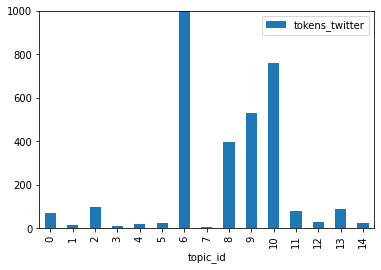

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
tokens_topics_df.groupby('topic_id').count().plot.bar(ylim=0)
plt.ylim(0,1000)
tokens_topics_df.groupby('topic_id').count()

Cortamos el DF final para que no colapse Colab con la RAM máxima

In [44]:
tokens_topics_df['tokens_twitter_str']=tokens_twitter_str
tokens_topics_df=tokens_topics_df.head(500)

Caracterización de los Tokens

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', stop_words='english')
features = tfidf.fit_transform(tokens_topics_df.tokens_twitter_str).toarray()
labels = tokens_topics_df.topic_id
features.shape

(500, 77107)

Modelo NB

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(tokens_topics_df['tokens_twitter'], tokens_topics_df['topic_id'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

AttributeError: ignored

In [50]:
type(clf)

sklearn.naive_bayes.MultinomialNB

Aplicamos una prueba

In [49]:
print(clf.predict(count_vect.transform(["This is the maximum climate change in the last 10 years"])))

[5]


In [51]:
y_pred=clf.predict(X_test)

ValueError: ignored

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

# REFERENCIAS 

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://datascienceplus.com/multi-class-text-classification-with-scikit-learn/ 